<a href="https://colab.research.google.com/github/timdresv/Accents/blob/main/lab_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [30]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [31]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Программист",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [32]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [33]:
id_s = ["25", "96", "150", "164", "165"]

params={
    "per_page":100
}

data=dict()

for id in id_s:
  params.update({"professional_role":id})

  data[id]=requests.get(URL, params).json()
  for page in range(1,data[id]["pages"]):
    data[id].update(requests.get(URL, params).json())

(1 балл) Посчитайте сколько всего найдено вакансий:

In [34]:
sum([data[id]["found"] for id in data.keys()])

25972

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [35]:
class Company:
  def __init__(self, name, lat, lng):
    self.name = name
    self.lat = lat
    self.lng = lng

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [36]:
companies=[]
employer_id_s=set()

for id in id_s:
  for item in data[id]["items"]:
    if "id" in item["employer"] and item["employer"]["id"] not in employer_id_s:
      employer_id_s.update({item["employer"]["id"]})
      coordinates = [None, None]
      if item["address"]:
        coordinates = item["address"]["lat"], item["address"]["lng"]
      companies.append(Company(item["employer"]["name"], *coordinates))

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [37]:
count=0

for id in id_s:
  for item in data[id]["items"]:
    if item["address"] and item["address"]["lat"]:
      count+=1

print(count)

189


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [38]:
center = {"lat":55.750604, "lng":37.616091}
radius = 0.2
vacancies = []

for id in id_s:
  for item in data[id]["items"]:
    if item["address"] and item["address"]["lat"]:
      lat, lng = item["address"]["lat"], item["address"]["lng"]
      if (lat - center["lat"]) * (lat - center["lat"]) + (lng - center["lng"]) * (lng - center["lng"]) < radius * radius:
        vacancies.append(item)



(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

<Axes: xlabel='lat', ylabel='lng'>

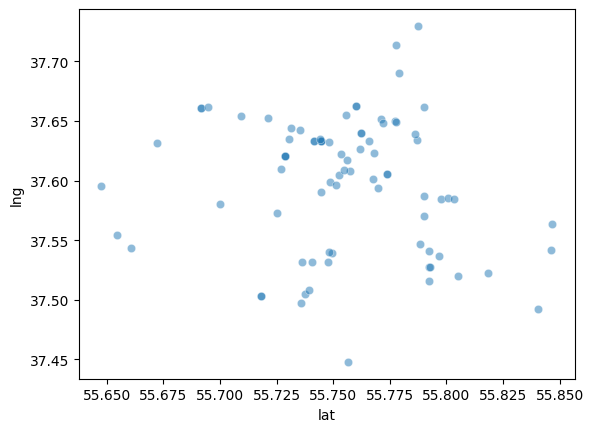

In [39]:
data_frame = pd.DataFrame(vacancies)

address = data_frame["address"].apply(pd.Series)
del address["id"]

data_frame = data_frame.join(address).join(data_frame["salary"].apply(pd.Series))

data_frame = data_frame.rename(columns={'from': 'salary_from', 'to': 'salary_to'})

sns.scatterplot(
                data=data_frame,
                x="lat",
                y="lng",
                alpha=0.5
               )

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [40]:
import pandas as pd

import plotly.express as px

fig = px.scatter_mapbox(data_frame, lat="lat", lon="lng", hover_name="name", hover_data=["raw","salary_from","salary_to","currency"], center={"lat":center["lat"],"lon":center["lng"]}, zoom=9, height=300, opacity=0.9)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Больше всего вакансий по выбранным мной специальностям находятся в районе Дорогомилово

В большинстве вакансий не указана зарплата

В Москве высокий спрос на вакансию программист (около 27 тыс. вакансий)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [41]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 61.5MB/s]


Создадим DataFrame:

In [42]:
diamonds = pd.read_csv("diamonds.csv")

(0.5 балла) Выведете первые 5 строк датасета:

In [43]:
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [44]:
diamonds.size

5712278

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [45]:
mx_idx = diamonds["total_sales_price"].idxmax()
mn_idx = diamonds["total_sales_price"].idxmin()

print(mx_idx, '-', diamonds["total_sales_price"][mx_idx])
print(mn_idx, '-', diamonds["total_sales_price"][mn_idx])

219702 - 1449881
0 - 200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [46]:
diamonds.eq('unknown').sum().sum() + diamonds.isnull().sum().sum()

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [47]:
for key in diamonds.keys():
  if diamonds[key].eq('unknown').sum() + diamonds[key].isnull().sum():
    print(key)

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [48]:
columns = [key for key in diamonds.keys() if key.startswith('fancy_color_') or key.startswith('fluor_')]
len(columns)

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [49]:
sum=0
for col in columns:
  sum += diamonds[col].eq('unknown').sum() + diamonds[col].isnull().sum()
sum

1206632

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [50]:
for col in columns:
  del diamonds[col]

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [51]:
columns = [key for key in diamonds.keys() if key.startswith('culet_')]
len(columns)

sum=0
for col in columns:
  sum += diamonds[col].eq('unknown').sum() + diamonds[col].isnull().sum()
sum

for col in columns:
  del diamonds[col]

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [52]:
diamonds["total_sales_price"].sum() // 1000

1517721

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [53]:
diamonds.loc[::2]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [54]:
diamonds.loc[::6]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [55]:
categorial = ['cut', 'color', 'clarity', 'cut_quality', 'polish', 'eye_clean', 'girdle_min', 'girdle_max']

diamonds[categorial]

,cut,color,clarity,cut_quality,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [56]:
arr = diamonds['total_sales_price'][:1000].to_numpy()

np.outer(arr,arr.T)

array([[ 40000,  40000,  40000, ...,  84000,  84000,  84000],
       [ 40000,  40000,  40000, ...,  84000,  84000,  84000],
       [ 40000,  40000,  40000, ...,  84000,  84000,  84000],
       ...,
       [ 84000,  84000,  84000, ..., 176400, 176400, 176400],
       [ 84000,  84000,  84000, ..., 176400, 176400, 176400],
       [ 84000,  84000,  84000, ..., 176400, 176400, 176400]])

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

Text(0, 0.5, 'стоимость')

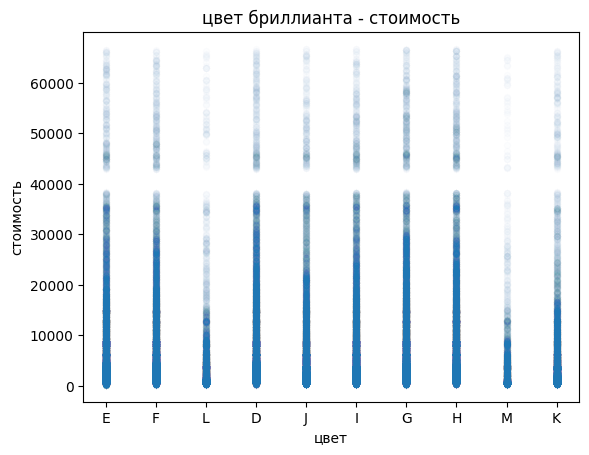

In [57]:
z_scores = np.abs((diamonds['total_sales_price'] - diamonds['total_sales_price'].mean()) / diamonds['total_sales_price'].std())
diamonds_clean = diamonds[(z_scores < 3) & (diamonds['color']!='unknown')]

ax = diamonds_clean.plot.scatter(title="цвет бриллианта - стоимость",x="color", y="total_sales_price", alpha=0.01)
ax.set_xlabel("цвет")
ax.set_ylabel("стоимость")

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

Text(0, 0.5, 'количество')

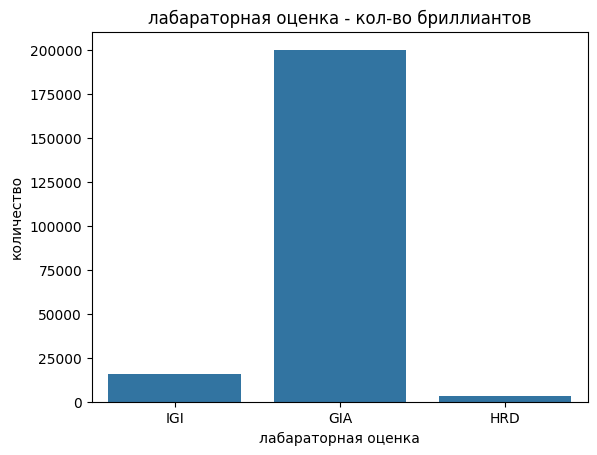

In [58]:
ax=sns.countplot(x='lab', data=diamonds)
ax.set_title('лабараторная оценка - кол-во бриллиантов')
ax.set_xlabel('лабараторная оценка')
ax.set_ylabel('количество')

(2 балла) Постройте график `вес бриллианта - стоимость`:

Text(0, 0.5, 'стоимость')

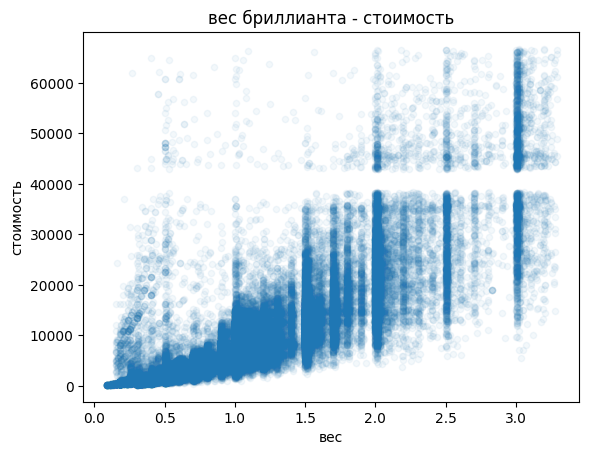

In [59]:
z_scores1 = np.abs((diamonds['total_sales_price'] - diamonds['total_sales_price'].mean()) / diamonds['total_sales_price'].std())
z_scores2 = np.abs((diamonds['carat_weight'] - diamonds['carat_weight'].mean()) / diamonds['carat_weight'].std())
diamonds_clean = diamonds[(z_scores1 < 3) & (z_scores2 < 3)]

ax = diamonds_clean.plot.scatter(title="вес бриллианта - стоимость",x="carat_weight", y="total_sales_price", alpha=0.05)
ax.set_xlabel("вес")
ax.set_ylabel("стоимость")

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

Text(0, 0.5, 'количество')

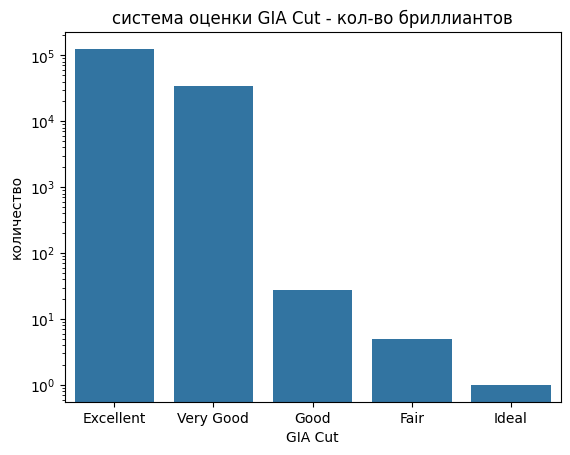

In [60]:
ax=sns.countplot(x='cut_quality', data=diamonds[diamonds['cut_quality']!='unknown'])
ax.set_title('система оценки GIA Cut - кол-во бриллиантов')
ax.set_xlabel('GIA Cut')
ax.set_yscale('log')
ax.set_ylabel('количество')


(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Среди алмазов цвета M меньше всего дорогих (дороже 400 тыс.)

Почти все алмазы имеют лабараторную оценку GIA

Алмазов с оценкой 'Excellent' и 'Very Good' на несколько порядков больше остальных

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [61]:
data = pd.read_csv("diamonds.csv")

columns = ['meas_length','meas_width','meas_depth','total_sales_price']
data=data[columns]

data.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [62]:
data = data.sample(frac=1)

(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [63]:
data=data.assign(minkowski_sum=(data['meas_depth']**2+data['meas_length']**2+data['meas_width']**2)**0.5)

(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [64]:
data = data[['minkowski_sum','total_sales_price']]

(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [65]:
data_train, data_test = data[:data['total_sales_price'].size*8//10], data[data['total_sales_price'].size*8//10:]

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

Text(0, 0.5, 'Стоимость')

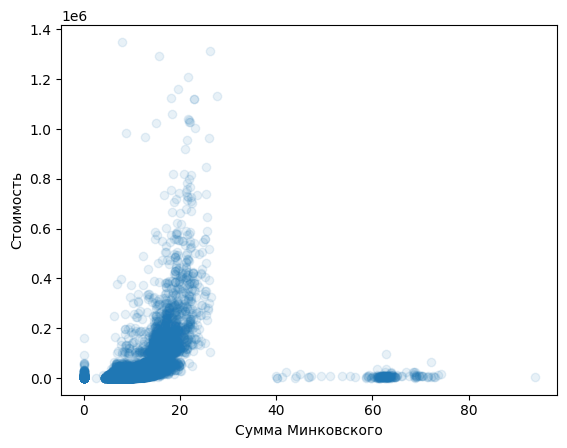

In [66]:
plt.scatter(x=data_train["minkowski_sum"], y=data_train["total_sales_price"], alpha=0.1)
plt.xlabel("Сумма Минковского")
plt.ylabel("Стоимость")

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

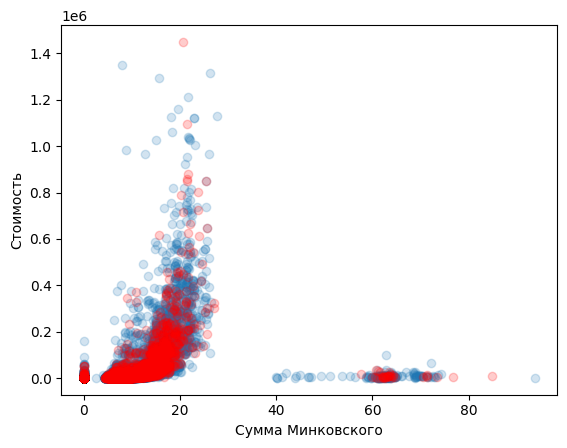

In [67]:
plt.scatter(x=data_train["minkowski_sum"], y=data_train["total_sales_price"], alpha=0.2)
plt.xlabel("Сумма Минковского")
plt.ylabel("Стоимость")
plt.scatter(x=data_test["minkowski_sum"], y=data_test["total_sales_price"], alpha=0.2, color='red')

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [68]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [69]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [70]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [71]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [72]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [73]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)